# CUHK [STAT3009](https://www.bendai.org/STAT3009/) Notebook9: Smooth Recommender Systems

## load the developed methods

In [2]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_rating):
		self.glb_mean = np.mean(train_rating)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred
 
class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## load dataset

In [3]:
import numpy as np
import pandas as pd

dtrain = pd.read_csv('./dataset/train.csv')
dtest = pd.read_csv('./dataset/test.csv')
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

## convert string to user_id and item_id -> [user_id, item_id, rating]
# pre-process for training data
train_pair = dtrain[['user_id', 'movie_id']].values
train_rating = dtrain['rating'].values
# pre-process for testing set
test_pair = dtest[['user_id', 'movie_id']].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Define and training the predictive models based on `class`

In [4]:
## baseline user mean methods
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred_user = user_ave.predict(test_pair)
print('RMSE for user_mean: %.3f' %rmse(test_rating, pred_user) )

RMSE for user_mean: 1.017


In [5]:
## baseline item mean methods
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred_item = item_ave.predict(test_pair)
print('RMSE for item_mean: %.3f' %rmse(test_rating, pred_item) )

RMSE for item_mean: 1.052


3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.797, valid_rmse: 1.286
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.773, valid_rmse: 1.192
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.789, valid_rmse: 1.221
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.777, valid_rmse: 1.129
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.776, valid_rmse: 1.103
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.766, valid_rmse: 1.070
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.785, valid_rmse: 1.035
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.767, valid_rmse: 1.035
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.772, valid_rmse: 1.026
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.808, valid_rmse: 1.025
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.787, valid_rmse: 1.004
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.786, valid_rmse: 1.002
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.825, valid_rmse: 0.942
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.825, valid_rmse: 0.975
3-Fold

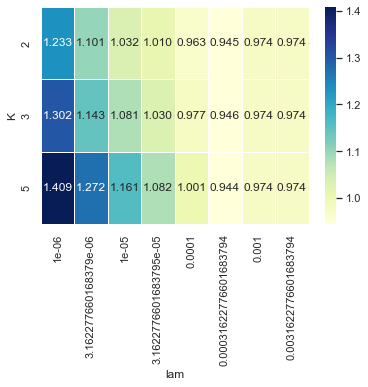

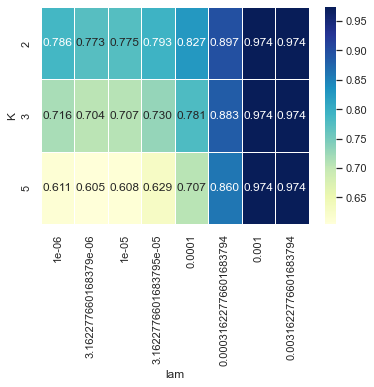

In [6]:
## CV based on `LFM_CV`
## Baseline + LFM
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
dtrain['res_rating'] = train_rating_res
pred = pred + user_ave.predict(test_pair)
# fit LFM_CV by residual ratings 
Ks, lams = [2, 3, 5], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [7]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
print('best K: %d, best lam: %.5f' %(best_K, best_lam))
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
print('RMSE for glb + user_mean + LFM: %.3f' %rmse(test_rating, pred))

best K: 5, best lam: 0.00032
Fitting Reg-LFM: K: 5, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.614 RMSE: 0.962
Reg-LFM: ite: 1; diff: 0.006 RMSE: 0.955
Reg-LFM: ite: 2; diff: 0.029 RMSE: 0.928
Reg-LFM: ite: 3; diff: 0.019 RMSE: 0.910
Reg-LFM: ite: 4; diff: 0.007 RMSE: 0.903
Reg-LFM: ite: 5; diff: 0.003 RMSE: 0.900
Reg-LFM: ite: 6; diff: 0.002 RMSE: 0.899
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.897
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.896
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.895
RMSE for glb + user_mean + LFM: 0.979


## Smooth Recommender Systems
## Step 1: Generate the side info for users and items

In [8]:
from sklearn.preprocessing import StandardScaler

user_info = pd.DataFrame({'user_id': list(range(n_user))})
user_info = user_info.set_index('user_id')
user_info['mean'] = dtrain.groupby('user_id')['res_rating'].mean()
user_info['q1'] = dtrain.groupby('user_id')['res_rating'].quantile(.1)
user_info['q3'] = dtrain.groupby('user_id')['res_rating'].quantile(.3)
user_info['q5'] = dtrain.groupby('user_id')['res_rating'].quantile(.5)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.7)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)

movie_info = pd.DataFrame({'movie_id': list(range(n_item))})
movie_info = movie_info.set_index('movie_id')
movie_info['mean'] = dtrain.groupby('movie_id')['res_rating'].mean()
movie_info['q1'] = dtrain.groupby('movie_id')['res_rating'].quantile(.1)
movie_info['q3'] = dtrain.groupby('movie_id')['res_rating'].quantile(.3)
movie_info['q5'] = dtrain.groupby('movie_id')['res_rating'].quantile(.5)
movie_info['q7'] = dtrain.groupby('movie_id')['res_rating'].quantile(.7)
movie_info['q7'] = dtrain.groupby('movie_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
movie_info = movie_info.fillna(movie_info.mean())
movie_scaler = StandardScaler()
movie_info = movie_scaler.fit_transform(movie_info)

In [11]:
print(user_info)

[[-1.0315618   1.05850582 -0.02319006 -1.39764211 -0.48154588]
 [-0.90490839 -0.10229335  0.85788798 -0.41551526  0.15662188]
 [-0.5145541   1.42729947  0.57230945 -0.73384613 -0.0502236 ]
 ...
 [ 0.25114084 -0.46198666  0.277083    0.47279993 -0.26405711]
 [-2.56183774 -0.18060362 -2.02400827 -0.55646683  0.06503418]
 [-0.30332791 -1.2122371  -0.93436347  0.65814682  0.85426755]]


In [12]:
print(movie_info)

[[ 4.85224769e-01  6.94967608e-01  5.95315093e-01  5.55553257e-01
   1.35882842e-01]
 [ 1.11166566e+00  9.96700910e-01  9.01591603e-01  1.07242191e+00
   8.82532034e-01]
 [-1.36848544e+00 -1.77207503e+00 -1.74277289e+00 -1.36285245e+00
  -5.51153706e-01]
 ...
 [ 4.08949061e-01  1.75545534e-01  1.56393783e-01  3.64584190e-01
   5.27400493e-01]
 [ 3.95181292e-17  1.38893543e-16  0.00000000e+00 -3.81204540e-17
   0.00000000e+00]
 [-1.07964765e-01  4.72285921e-01  1.83952745e-01 -1.40179435e-02
  -6.22917412e-01]]


## Step 2: Weight matrix

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
movie_sim = cosine_similarity(movie_info)

## Step 2: Compute the augmented dataset

In [14]:
top = 5
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):+
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_movie_tmp = train_pair[valid_user_ind,1]
	for i in range(n_item):
		top_movie_tmp = movie_sim[i].argsort()[-top:][::-1]
		valid_movie_tmp = np.intersect1d(top_movie_tmp, obs_movie_tmp)
		if len(valid_movie_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_movie_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2
UserId: 3
UserId: 4
UserId: 5
UserId: 6
UserId: 7
UserId: 8
UserId: 9
UserId: 10
UserId: 11
UserId: 12
UserId: 13
UserId: 14
UserId: 15
UserId: 16
UserId: 17
UserId: 18
UserId: 19
UserId: 20
UserId: 21
UserId: 22
UserId: 23
UserId: 24
UserId: 25
UserId: 26
UserId: 27
UserId: 28
UserId: 29
UserId: 30
UserId: 31
UserId: 32
UserId: 33
UserId: 34
UserId: 35
UserId: 36
UserId: 37
UserId: 38
UserId: 39
UserId: 40
UserId: 41
UserId: 42
UserId: 43
UserId: 44
UserId: 45
UserId: 46
UserId: 47
UserId: 48
UserId: 49
UserId: 50
UserId: 51
UserId: 52
UserId: 53
UserId: 54
UserId: 55
UserId: 56
UserId: 57
UserId: 58
UserId: 59
UserId: 60
UserId: 61
UserId: 62
UserId: 63
UserId: 64
UserId: 65
UserId: 66
UserId: 67
UserId: 68
UserId: 69
UserId: 70
UserId: 71
UserId: 72
UserId: 73
UserId: 74
UserId: 75
UserId: 76
UserId: 77
UserId: 78
UserId: 79
UserId: 80
UserId: 81
UserId: 82
UserId: 83
UserId: 84
UserId: 85
UserId: 86
UserId: 87
UserId: 88
UserId: 89
UserId: 90
UserId: 9

UserId: 692
UserId: 693
UserId: 694
UserId: 695
UserId: 696
UserId: 697
UserId: 698
UserId: 699
UserId: 700
UserId: 701
UserId: 702
UserId: 703
UserId: 704
UserId: 705
UserId: 706
UserId: 707
UserId: 708
UserId: 709
UserId: 710
UserId: 711
UserId: 712
UserId: 713
UserId: 714
UserId: 715
UserId: 716
UserId: 717
UserId: 718
UserId: 719
UserId: 720
UserId: 721
UserId: 722
UserId: 723
UserId: 724
UserId: 725
UserId: 726
UserId: 727
UserId: 728
UserId: 729
UserId: 730
UserId: 731
UserId: 732
UserId: 733
UserId: 734
UserId: 735
UserId: 736
UserId: 737
UserId: 738
UserId: 739
UserId: 740
UserId: 741
UserId: 742
UserId: 743
UserId: 744
UserId: 745
UserId: 746
UserId: 747
UserId: 748
UserId: 749
UserId: 750
UserId: 751
UserId: 752
UserId: 753
UserId: 754
UserId: 755
UserId: 756
UserId: 757
UserId: 758
UserId: 759
UserId: 760
UserId: 761
UserId: 762
UserId: 763
UserId: 764
UserId: 765
UserId: 766
UserId: 767
UserId: 768
UserId: 769
UserId: 770
UserId: 771
UserId: 772
UserId: 773
UserId: 774
User

UserId: 1346
UserId: 1347
UserId: 1348
UserId: 1349
UserId: 1350
UserId: 1351
UserId: 1352
UserId: 1353
UserId: 1354
UserId: 1355
UserId: 1356
UserId: 1357
UserId: 1358
UserId: 1359
UserId: 1360
UserId: 1361
UserId: 1362
UserId: 1363
UserId: 1364
UserId: 1365
UserId: 1366
UserId: 1367
UserId: 1368
UserId: 1369
UserId: 1370
UserId: 1371
UserId: 1372
UserId: 1373
UserId: 1374
UserId: 1375
UserId: 1376
UserId: 1377
UserId: 1378
UserId: 1379
UserId: 1380
UserId: 1381
UserId: 1382
UserId: 1383
UserId: 1384
UserId: 1385
UserId: 1386
UserId: 1387
UserId: 1388
UserId: 1389
UserId: 1390
UserId: 1391
UserId: 1392
UserId: 1393
UserId: 1394
UserId: 1395
UserId: 1396
UserId: 1397
UserId: 1398
UserId: 1399
UserId: 1400
UserId: 1401
UserId: 1402
UserId: 1403
UserId: 1404
UserId: 1405
UserId: 1406
UserId: 1407
UserId: 1408
UserId: 1409
UserId: 1410
UserId: 1411
UserId: 1412
UserId: 1413
UserId: 1414
UserId: 1415
UserId: 1416
UserId: 1417
UserId: 1418
UserId: 1419
UserId: 1420
UserId: 1421
UserId: 1422

UserId: 1977
UserId: 1978
UserId: 1979
UserId: 1980
UserId: 1981
UserId: 1982
UserId: 1983
UserId: 1984
UserId: 1985
UserId: 1986
UserId: 1987
UserId: 1988
UserId: 1989
UserId: 1990
UserId: 1991
UserId: 1992
UserId: 1993
UserId: 1994
UserId: 1995
UserId: 1996
UserId: 1997
UserId: 1998
UserId: 1999


## Step 3: Fit a Latent Factor Model

In [15]:
aug_pair, aug_rating_res = np.vstack((train_pair, fake_pair)), np.hstack((train_rating_res, fake_rating))

## fit the LFM model with augmentated dataset
K, lam = 5, 0.0001
sSVD=LFM(n_user, n_item, K=K, lam=lam)
sSVD.fit(aug_pair, aug_rating_res)

Fitting Reg-LFM: K: 5, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.635 RMSE: 0.877
Reg-LFM: ite: 1; diff: 0.014 RMSE: 0.865
Reg-LFM: ite: 2; diff: 0.073 RMSE: 0.802
Reg-LFM: ite: 3; diff: 0.009 RMSE: 0.795
Reg-LFM: ite: 4; diff: 0.001 RMSE: 0.794
Reg-LFM: ite: 5; diff: 0.000 RMSE: 0.794
Reg-LFM: ite: 6; diff: 0.000 RMSE: 0.794
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.793
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.793
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.792


In [16]:
## Baseline + LFM
pred = glb_ave.predict(test_pair)
# user_mean
pred = pred + user_ave.predict(test_pair)
pred = pred + sSVD.predict(test_pair)
print('RMSE for glb + user_mean + smooth LFM: %.3f' %rmse(test_rating, pred))

RMSE for glb + user_mean + smooth LFM: 0.968


### Note1: the performance can be further improved by fair cross-validation on (`K`, `lam`) and even `top`

### Note2: the computation complexity is relative large for `augmentation step`, yet it might be solved by `SGD`.